In [121]:
#--- 1. Imports ---
import numpy as np
import matplotlib.pyplot as plt

from datagen import TestLinear
from solver import SVM_Solver
from utils import compute_objective

In [122]:
# --- 2. Generate Test Data ---

# Define the hyperplane parameters
w_true = np.array([3.0, 13.0])
b_true = 0.0
margin = 0.5
n_A = 5000
n_B = 5000

# Generate the dataset from the given python code from the description
listA, listB = TestLinear(w_true, b_true, n_A, n_B, margin)

# Combine the data
X = np.array(listA + listB)
y = np.array([-1]*n_A + [1]*n_B)

M, d = X.shape
print(f"Generated {M} points in {d} dimensions.")


Generated 10000 points in 2 dimensions.


In [123]:
# --- 3. Construct the Gram Matrix G ---

G = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        G[i, j] = np.dot(X[i], X[j])


In [124]:
# --- 4. Solve the Dual Problem ---

C = 30  # Regularization parameter (large value approximates hard margin)
tau_min = 1e-5  # Minimum step size
tau_max = 1e5  # Maximum step size
max_iter = 1000  # Maximum iterations before stop (current alpha becomes result)
tol = 1e-5  # Tolerance before convergence is complete (tau<tol == complete convergence)
use_line_search = True  # Toggle simple line search

# Call on SVM_Solver class
solver = SVM_Solver(G, y, C, tau_min, tau_max, max_iter, tol, use_line_search) 
alpha_star = solver.solve() # Returns alpha* 

Iteration 0: Objective = 9845.672739, Step size tau = 4.45e-05
Converged at iteration 2


In [125]:
# --- 5. Recover w* and b* ---

# Support vectors indices
support_indices = np.where(alpha_star > 1e-5)[0]

# Compute w*
w_star = np.sum((alpha_star[support_indices] * y[support_indices])[:, None] * X[support_indices], axis=0)

# Compute b* using points with 0 < alpha_i < C
support_interior = np.where((alpha_star > 1e-5) & (alpha_star < C))[0]
if len(support_interior) > 0:
    b_star = np.mean([y[i] - np.dot(w_star, X[i]) for i in support_interior])
else:
    b_star = 0  # fallback if no good points found
print(f"Recovered w*: {w_star}")
print(f"Recovered b*: {b_star}")

Recovered w*: [ -52072.13910768 -217716.47204648]
Recovered b*: 0


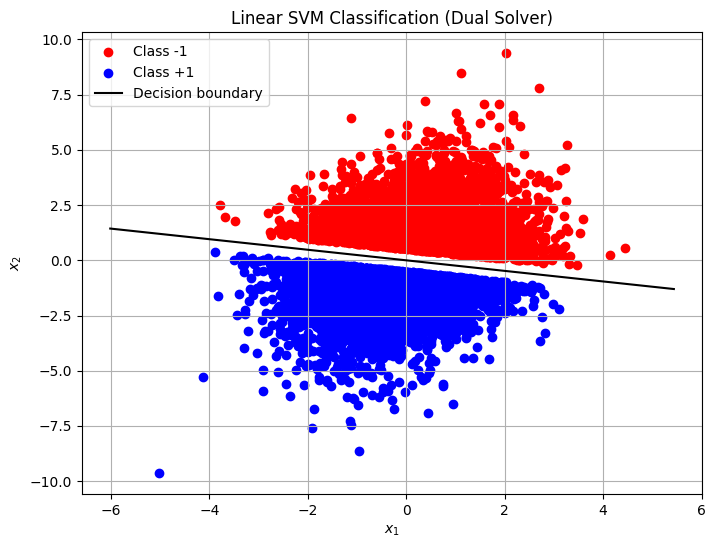

In [126]:
# --- 6. Build Classifier and Plot ---

def classifier(x):
    return np.sign(np.dot(w_star, x) + b_star)

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class +1')

x_plot = np.linspace(np.min(X[:, 0])-1, np.max(X[:, 0])+1, 100)

# Print with errorhandling
if np.abs(w_star[1]) > 1e-8:
    y_plot = -(w_star[0] * x_plot + b_star) / w_star[1]
    plt.plot(x_plot, y_plot, 'k-', label="Decision boundary")
elif np.abs(w_star[0]) > 1e-8:
    x_val = -b_star / w_star[0]
    plt.axvline(x=x_val, color='k', linestyle='--', label="Decision boundary")
else:
    print("Warning: both w_star components are too small to plot a meaningful decision boundary.")

plt.legend()
plt.title("Linear SVM Classification (Dual Solver)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.show()


In [127]:
print("Number of support vectors:", len(support_indices))
print("Number of free support vectors (0 < alpha < C):", len(support_interior))
print("Max alpha:", np.max(alpha_star))
print("Min alpha:", np.min(alpha_star))

Number of support vectors: 5000
Number of free support vectors (0 < alpha < C): 0
Max alpha: 30.0
Min alpha: 0.0


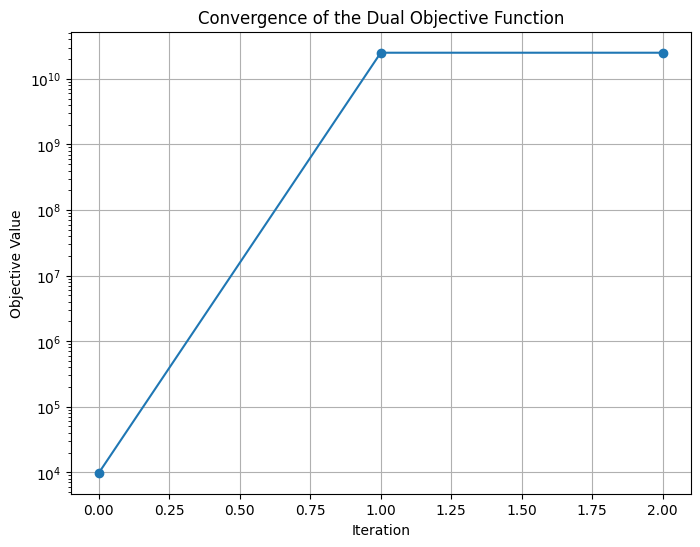

In [128]:
plt.figure(figsize=(8,6))
plt.plot(range(len(solver.objective_values)), solver.objective_values, marker='o')
plt.yscale('log')  # (Optional: Log scale because objective drops fast!)
plt.title("Convergence of the Dual Objective Function")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()
